In [ ]:
import warnings
warnings.filterwarnings("ignore")
import numpy
import pandas
import matplotlib.pyplot as plt
import plotly.express as px
import pathlib
from glob import glob
import os
import PIL
import imageio
from scipy.signal import convolve2d
import matplotlib.image as mpimg
from tensorflow.keras.preprocessing import image
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau

import tensorflow as tf
from tensorflow import keras

from sklearn import metrics
import seaborn

# Reading Directory

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
mainpath='/content/drive/MyDrive/AnimalFaces/'
train_path=os.path.join(mainpath,'train')
valid_path=os.path.join(mainpath,'val')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
catimg=os.listdir(train_path)
catimg

['wild', 'dog', 'cat']

# Image Processing

In [ ]:
trpth=os.listdir(train_path)
valpth=os.listdir(valid_path)
trn_img=[]
val_img=[]
cats_img=catimg
for i in trpth:
    trn_img.append(len(os.listdir(os.path.join(train_path,i))))
for i in valpth:
    val_img.append(len(os.listdir(os.path.join(valid_path,i))))
tot=[sum(trn_img),sum(val_img)]
trn_img.append(tot[0])
val_img.append(tot[1])
cats_img.append("Total")
piedata=pandas.DataFrame({"Category":cats_img,"Train":trn_img,"Valid":val_img})
piedata

,Category,Train,Valid
0,wild,4738,500
1,dog,4735,500
2,cat,2889,500
3,Total,12362,1500


In [ ]:
fig=px.pie(piedata.iloc[:3],names="Category",values="Train",color="Category",title="Number of Images Train Set",height=400,width=400,
           color_discrete_sequence=px.colors.qualitative.Vivid)
fig.update_traces(textposition='inside',textinfo='percent+label+value')
fig.update_layout(
    font=dict(
        family="Times New Roman, Bold",
        size=20,
        color="black"
    )
)
fig.show()

In [ ]:
fig=px.pie(piedata.iloc[:3],names="Category",values="Valid",color="Category",title="Number of Images Validation Set",height=400,width=400,
           color_discrete_sequence=px.colors.qualitative.Pastel2)
fig.update_traces(textposition='inside',textinfo='percent+label+value')
fig.update_layout(
    font=dict(
        family="Times New Roman, Bold",
        size=20,
        color="black"
    )
)
fig.show()

In [ ]:
train_dir = pathlib.Path(train_path)

trn_wild = list(train_dir.glob("wild/*"))
trn_dog = list(train_dir.glob("dog/*"))
trn_cat = list(train_dir.glob("cat/*"))

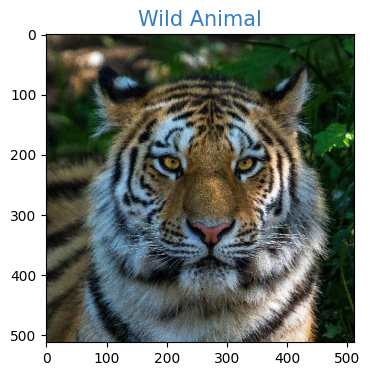

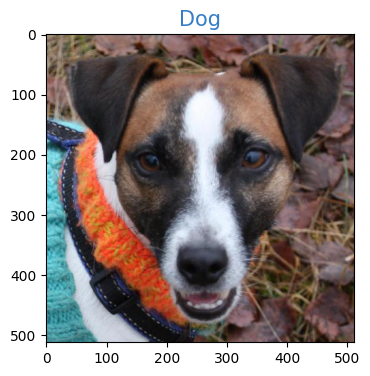

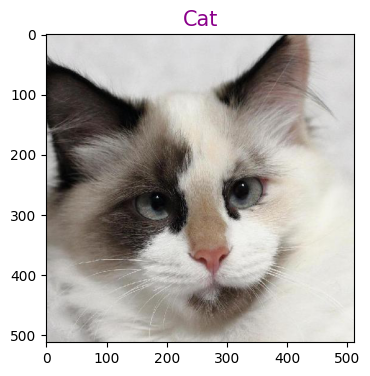

In [ ]:
img1 = PIL.Image.open(trn_wild[30])
plt.figure(figsize=(4,4))
plt.title("Wild Animal",fontsize=15,color="#357EC7")
plt.imshow(img1)

img2 = PIL.Image.open(trn_dog[30])
plt.figure(figsize=(4,4))
plt.title("Dog",fontsize=15,color="#357EC7")
plt.imshow(img2)

img3 = PIL.Image.open(trn_cat[30])
plt.figure(figsize=(4,4))
plt.title("Cat",fontsize=15,color="#8B008B")
plt.imshow(img3)

# Feature Extraction

In [ ]:
catimg=catimg[:-1]
catimg

['wild', 'dog', 'cat']

In [ ]:
train_datagen = image.ImageDataGenerator(rescale=1. / 255,
                                   rotation_range=50,
                                   width_shift_range=0.15,
                                   height_shift_range=0.15,
                                   shear_range=0.3,
                                   zoom_range=0.3,
                                   vertical_flip=True)

val_datagen = image.ImageDataGenerator(rescale=1. / 255)
bsiz = 48
img_h,img_w = 64,64

def image_preprocess1(pth, label):
  trainaug = train_datagen.flow_from_directory(
        pth,
        classes=label,
        target_size=(img_h, img_w),
        batch_size=bsiz,
        class_mode='categorical')
  return trainaug, label
def image_preprocess2(pth, label):
  valaug = val_datagen.flow_from_directory(
        pth,
        classes=label,
        target_size=(img_h, img_w),
        batch_size=bsiz,
        class_mode='categorical')
  return valaug, label
data_aug_train, caltmg=image_preprocess1(train_path, catimg)
data_aug_val, caltmg=image_preprocess2(valid_path, catimg)

Found 12362 images belonging to 3 classes.
Found 1500 images belonging to 3 classes.


In [ ]:
def Model_Pretrained(dptlm,mdlnm):
    mdl_trl = dptlm
    inpinslyr = keras.layers.Input(shape=(img_h,img_w, 3))
    hddninslyr = keras.layers.Conv2D(3, (3, 3), padding='same')(inpinslyr)
    hddninslyr = mdl_trl(hddninslyr)
    hddninslyr = keras.layers.GlobalAveragePooling2D()(hddninslyr)
    hddninslyr = keras.layers.BatchNormalization()(hddninslyr)
    hddninslyr = keras.layers.Dropout(0.5)(hddninslyr)
    hddninslyr = keras.layers.Dense(256, activation='relu')(hddninslyr)
    hddninslyr = keras.layers.BatchNormalization()(hddninslyr)
    hddninslyr = keras.layers.Dropout(0.5)(hddninslyr)
    outinslyr = keras.layers.Dense(3,activation = 'softmax')(hddninslyr)
    deepemo = keras.models.Model(inpinslyr,outinslyr, name="{}".format(mdlnm))
    deepemo.compile(loss='categorical_crossentropy', metrics=['accuracy'])
    deepemo.summary()
    return deepemo

In [ ]:
pre_trained=keras.applications.VGG19(include_top=False,weights=None,input_tensor=None,input_shape=None,pooling=None,classes=2)
MONITOR_R = ReduceLROnPlateau(monitor='val_accuracy', factor=0.4, verbose=1, min_lr=0.00001, patience=0.2)
MONITOR_MC = ModelCheckpoint('vggmodel.h5', verbose=1, save_best_only=True)
VGGNET = Model_Pretrained(pre_trained, "vgg")
vggfit = VGGNET.fit_generator(
    data_aug_train,
    epochs=100,
    verbose=1,
    callbacks=[MONITOR_R, MONITOR_MC],
    validation_data=data_aug_val) 

Model: "vgg"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_10 (InputLayer)       [(None, 64, 64, 3)]       0         
                                                                 
 conv2d_4 (Conv2D)           (None, 64, 64, 3)         84        
                                                                 
 vgg19 (Functional)          (None, None, None, 512)   20024384  
                                                                 
 global_average_pooling2d_4   (None, 512)              0         
 (GlobalAveragePooling2D)                                        
                                                                 
 batch_normalization_8 (Batc  (None, 512)              2048      
 hNormalization)                                                 
                                                                 
 dropout_8 (Dropout)         (None, 512)               0       

## Model Evaluation and Predition to Prepare Metrics

In [ ]:
def evaluatemodel(model,data,typ):
    LOSS, ACC = model.evaluate(data)
    print('{} Loss: {}, {} Accuracy: {}%\n'.format(typ,LOSS, typ,round(ACC,3)*100))
    return LOSS, ACC

In [ ]:
def predmodel(model,data):
    predicted = model.predict(data)
    predicted = numpy.argmax(predicted, axis=1)
    class_actual = data.classes

    cm = metrics.confusion_matrix(class_actual, predicted)
    plt.figure(figsize=(8,4))
    ax = seaborn.heatmap(cm, fmt="d",annot=True,cmap='rainbow', xticklabels=catimg, yticklabels=catimg)
    ax.set_ylabel('Actual', fontsize=25)
    ax.set_xlabel('Detected', fontsize=25)
    plt.show()

In [ ]:
def VizGraph(trainedres):
    df=pandas.DataFrame({
        "Epoch":["{}".format(i+1) for i in range(100)],
        "Train_Loss":trainedres.history['loss'],
        "Valid_Loss":trainedres.history['val_loss'],
        "Train_Accuracy":trainedres.history['accuracy'],
        "Valid_Accuracy":trainedres.history['val_accuracy']
    })

    df.to_csv("Result.csv")
    ttlclr="#6A0DAD"
    fpos,lpos=1,3
    df.iloc[:,lpos:].plot(kind="line",figsize=(10,5),color=["#00BFFF","#F75D59"])
    plt.title("Accuracies for VGG19 Model",fontsize=20,color=ttlclr)
    plt.xlabel("Iteration",fontsize=20,color=ttlclr)
    plt.ylabel("Accuracies",fontsize=20,color=ttlclr)
    plt.grid()
    plt.show()

    df.iloc[:,fpos:lpos].plot(kind="line",figsize=(10,5),color=["#00BFFF","#F75D59"])
    plt.title("Losses for VGG19 Model",fontsize=20,color=ttlclr)
    plt.xlabel("Iteration",fontsize=20,color=ttlclr)
    plt.ylabel("Model Loss",fontsize=20,color=ttlclr)
    plt.grid()
    plt.show()

258/258 [==============================] - 78s 301ms/step - loss: 0.0671 - accuracy: 0.9752
Train Loss: 0.06705041229724884, Train Accuracy: 97.5%

32/32 [==============================] - 8s 239ms/step - loss: 0.0715 - accuracy: 0.9793
Validation Loss: 0.07152862846851349, Validation Accuracy: 97.89999999999999%

32/32 [==============================] - 8s 241ms/step


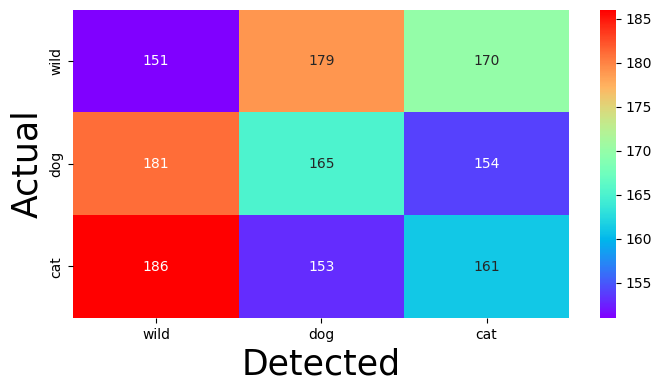

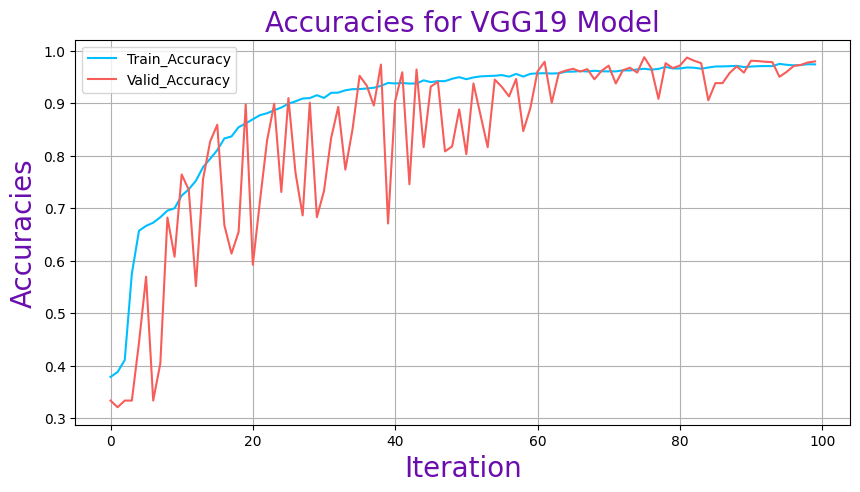

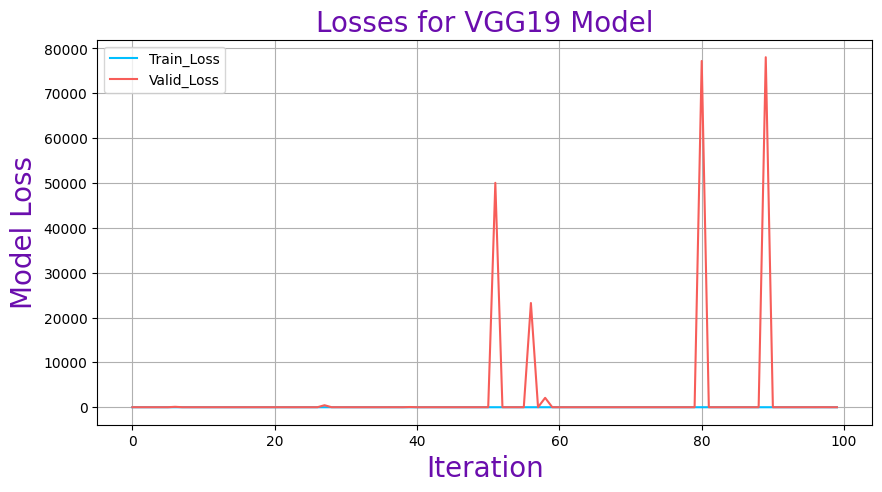

In [ ]:
data_all=["Train","Validation"]
augdata=[data_aug_train,data_aug_val]
metloss,metacc=[],[]
for d in range(len(data_all)):
    L,A=evaluatemodel(VGGNET,augdata[d],data_all[d])
    metloss.append(L)
    metacc.append(A)

predmodel(VGGNET,augdata[1])

VizGraph(vggfit)

In [ ]:
VGGNET.save("VGG19.h5")